# Section 5.5 Practical course material: Effectvie kernel of large dimensional random Fourier features

This page contains simulations in Section 5.5 Practical course material.

## Contents

    - Training MSEs of random Fourier feature and Gaussian kernel regressions


## Training MSEs of random Fourier feature and Gaussian kernel regressions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist,fashion_mnist
pi = np.pi

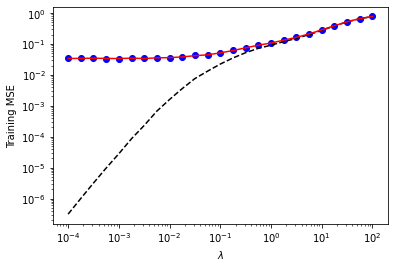

In [30]:
testcase='MNIST' # among 'MNIST', 'fashion'

n = 1024
N = 256
cs = [1/2,1/2]
k = len(cs)

if testcase == 'MNIST':
    selected_labels=[3,7]
    (init_data, init_labels), _ = mnist.load_data()

if testcase == 'fashion':
    selected_labels=[1,2]
    (init_data, init_labels), _ = fashion_mnist.load_data()
    
idx_init_labels = np.argsort(np.array(init_labels))    
labels = init_labels[idx_init_labels]
init_data = init_data[idx_init_labels,:,:]
data = np.transpose(init_data.reshape(np.shape(init_data)[0],np.shape(init_data)[1]*np.shape(init_data)[2]))
init_n,p=np.shape(data)[1],np.shape(data)[0]

data = data/data.max()
mean_data=np.mean(data,axis=1).reshape(len(data),1)

norm2_data=0
for i in range(init_n):
    norm2_data+=1/init_n*np.linalg.norm(data[:,i]-mean_data)**2

data=(data-mean_data)/np.sqrt(norm2_data)*np.sqrt(p)

selected_data = []

for i in range(len(selected_labels)):
    selected_data.append(data[:,[ x for x in range(init_n) if labels[x]==selected_labels[i] ] ])
    if i==0:    
        cascade_selected_data = selected_data[-1]
    else:
        np.concatenate([cascade_selected_data,selected_data[-1]],axis=1)

# recentering of the k classes
mean_selected_data  = np.mean(cascade_selected_data,axis=1).reshape(len(cascade_selected_data),1)
norm2_selected_data = np.mean(np.sum(np.power(np.abs(cascade_selected_data-mean_selected_data),2),0))

for j in range(len(selected_labels)):
    selected_data[j]=(selected_data[j]-mean_selected_data)/np.sqrt(norm2_selected_data)*np.sqrt(p)

nb_data_loop = 30
gamma_loop = 10**np.arange(-4,2.25,.25)

store_MSE_train_1 = np.zeros((len(gamma_loop),nb_data_loop))
store_MSE_train_2 = np.zeros((len(gamma_loop),nb_data_loop))

theo_MSE_train = np.zeros((len(gamma_loop),nb_data_loop))

for gamma_index,gamma in enumerate(gamma_loop):

    for data_loop in range(nb_data_loop):

        # empirical evaluation
        X=np.zeros((p,n))
        y=np.zeros(n)

        for i in range(k):
            data = selected_data[i][:,np.random.permutation(np.shape(selected_data[i])[1])]
            X[:,int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)]=data[:,:int(n*cs[i])]
            y[int(np.sum(cs[:i])*n):int(np.sum(cs[:i+1])*n)] = (-1)**i
        
        X = X/np.sqrt(p) # renormalization of the data

        W = np.random.randn(N,p)
        Sigma = np.concatenate([np.cos(W@X),np.sin(W@X)])

        XX = X.T@X
        K_gauss = np.exp(-1/2*(-2*XX+np.diag(XX).reshape(n,1)+np.diag(XX).reshape(1,n)))

        beta = Sigma@np.linalg.solve(Sigma.T@Sigma/n+gamma*np.eye(n),y)/n
        store_MSE_train_1[gamma_index,data_loop] = np.linalg.norm(y - Sigma.T@beta)**2/n
        store_MSE_train_2[gamma_index,data_loop] = gamma**2/n*np.linalg.norm(np.linalg.solve(N/n*K_gauss+gamma*np.eye(n),y))**2

        # theoretical results
        K_cos_f = lambda x,y : np.diag(np.exp(-np.diag(x.T@x/2)))@np.cosh(x.T@y)@np.diag(np.exp(-np.diag(y.T@y/2)))
        K_sin_f = lambda x,y : np.diag(np.exp(-np.diag(x.T@x/2)))@np.sinh(x.T@y)@np.diag(np.exp(-np.diag(y.T@y/2)))

        K_cos = K_cos_f(X,X)
        K_sin = K_sin_f(X,X)

        delta = np.zeros(2)
        delta_tmp = np.ones(2)
        while np.max(np.abs(delta-delta_tmp))>1e-6:
            delta_tmp = delta.copy()

            delta[0] = np.trace( np.linalg.solve(N/n*( K_cos/(1+delta[0]) + K_sin/(1+delta[1]) ) + gamma*np.eye(n),K_cos) )/n
            delta[1] = np.trace( np.linalg.solve(N/n*( K_cos/(1+delta[0]) + K_sin/(1+delta[1]) ) + gamma*np.eye(n),K_sin) )/n

        bar_Q   = np.linalg.inv(N/n*( K_cos/(1+delta[0]) + K_sin/(1+delta[1]) ) + gamma*np.eye(n))
        bar_Q_y = np.linalg.solve(N/n*( K_cos/(1+delta[0]) + K_sin/(1+delta[1]) ) + gamma*np.eye(n),y)

        delta[0] = np.trace(K_cos@bar_Q)/n
        delta[1] = np.trace(K_sin@bar_Q)/n

        Delta = np.linalg.inv( np.eye(2) - N/n*np.array([ [np.trace(bar_Q@K_cos@bar_Q@K_cos)/n/(1+delta[0])**2,np.trace(bar_Q@K_cos@bar_Q@K_sin)/n/(1+delta[1])**2],[np.trace(bar_Q@K_cos@bar_Q@K_sin)/n/(1+delta[0])**2,np.trace(bar_Q@K_sin@bar_Q@K_sin)/n/(1+delta[1])**2]]) )
        tmp = np.array([np.trace(bar_Q@K_cos@bar_Q)/n/(1+delta[0])**2,np.trace(bar_Q@K_sin@bar_Q)/n/(1+delta[1])**2])@Delta
        theo_MSE_train[gamma_index,data_loop] = gamma**2*np.linalg.norm(bar_Q_y)**2/n + gamma**2*N/n*( tmp[0]*bar_Q_y.T@K_cos@bar_Q_y + tmp[1]*bar_Q_y.T@K_sin@bar_Q_y )/n

plt.loglog(gamma_loop,np.mean(store_MSE_train_1,1),'bo')
plt.loglog(gamma_loop,np.mean(store_MSE_train_2,1),'k--')
plt.loglog(gamma_loop,np.mean(theo_MSE_train,1),'r')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Training MSE')
_ = plt.show()
